In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cluster import HDBSCAN
# import seaborn as sns
import re

from skimage import io, color, filters, measure, morphology

In [3]:
all_images = os.listdir(os.path.join("..", "data_generation", "data", "final_renders"))
images = [img for img in all_images if re.search("Image", img)]
masks = [img for img in all_images if re.search("Segmentation", img)]

In [7]:
def get_mask_for_image(img):
    return img.replace("Image", "Segmentation")

img_path = images[0]
img =  Image.open(os.path.join("..", "data_generation", "data", "final_renders", img_path))
mask = Image.open(os.path.join("..", "data_generation", "data", "final_renders", get_mask_for_image(img_path)))
img_t = np.asarray(img)
mask_t = np.asarray(mask)

edge_mask = filters.sobel_h(color.rgb2gray(color.rgba2rgb(img_t)), mask_t)
edge_mask = edge_mask < filters.threshold_otsu(edge_mask)

In [9]:
np.transpose(np.where(edge_mask != True)).shape

(22187, 2)

In [11]:
def find_rows_img(img, mask, axes):
    mask_region = measure.regionprops(mask)
    angle = mask_region[0].orientation

    keyboard_not_so_vertical = angle > np.pi/4 or angle < -np.pi/4
    if keyboard_not_so_vertical:
        edge_mask = filters.sobel_h(color.rgb2gray(color.rgba2rgb(img)), mask) 
    else: 
        edge_mask = filters.sobel_v(color.rgb2gray(color.rgba2rgb(img)), mask) 

    edge_mask = edge_mask < filters.threshold_otsu(edge_mask)
    indicator = np.where(edge_mask == False)[0].size >= np.where(edge_mask == True)[0].size

    centers = np.transpose(np.where(edge_mask == indicator))

    if centers.shape[0] > 5000:
        centers = centers[np.random.choice(centers.shape[0], size = 5000, replace= False)]

    keyboard_center = (np.sum(mask_region[0].coords[:,1])/len(mask_region[0].coords),np.sum(mask_region[0].coords[:,0])/len(mask_region[0].coords))
    normalised_centers = np.transpose(np.asarray([centers[:,1] - keyboard_center[0], centers[:,0] - keyboard_center[1]]))
    sorted_centers = pd.DataFrame(normalised_centers, columns=["0","1"]).sort_values(by="1", ascending=False)

    multiplier = (1,1000)

    X = sorted_centers.copy()

    rot_angle = -np.pi /2 + angle
    rotation_matrix = np.matrix([[np.cos(rot_angle), -np.sin(rot_angle)], [np.sin(rot_angle), np.cos(rot_angle)]])

    X = X.apply(lambda x: np.matmul(rotation_matrix,x), axis= 1)
    X = pd.DataFrame(X.tolist(), columns=["0", "1"])
    X["0"] = X["0"]*multiplier[0]
    X["1"] = X["1"]*multiplier[1]

    m = HDBSCAN(min_cluster_size=20)
    m.fit(X)

    labels = m.labels_

    sorted_centers["rows"] = labels

    coefs = []

    sorted_centers["0"] = sorted_centers["0"] + keyboard_center[0]
    sorted_centers["1"] = sorted_centers["1"] + keyboard_center[1]

    row_counts = sorted_centers["rows"].value_counts()
    top_rows = row_counts.head(8).index
    sorted_centers = sorted_centers[sorted_centers["rows"].isin(top_rows)]

    for row in np.unique(sorted_centers["rows"]):
        if row == -1:
            continue
        cluster_data = sorted_centers.loc[sorted_centers["rows"] == row, ["0", "1"]]
        X_t = cluster_data["0"].values.reshape(-1, 1)  
        y_t = cluster_data["1"].values
        lr = LinearRegression()
        lr.fit(X_t,y_t)
        coefs.append((lr.coef_,lr.intercept_, row))

    #axes.imshow(edge_mask, cmap = "gray")
    #axes.imshow(img)
    axes.scatter(X["0"], X["1"])
    i = 0
    for (a,b,row) in coefs:
        x = np.linspace(0, img.shape[1], 100)
        y = a*x+b
        #axes.plot(x,y,color = "red")
        i+=1

    #axes.set_xlim([0, img.shape[1]])
    #axes.set_ylim([img.shape[0], 0])   
    axes.set_title(f"{np.rad2deg(angle)},{keyboard_not_so_vertical}")
    return coefs,axes

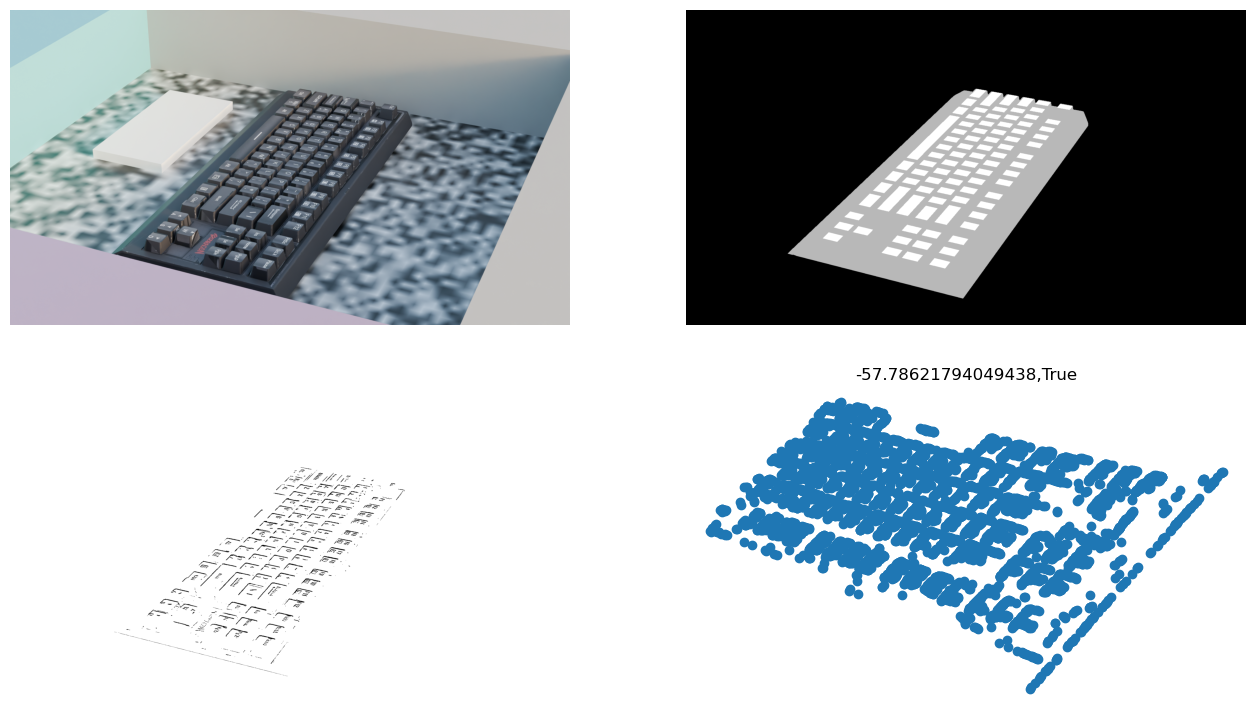

In [12]:
fig, ax = plt.subplots(2,2, figsize = [16,9])
ax  = ax.flatten()
ax[0].imshow(img_t)
ax[1].imshow(mask_t, cmap = "gray")
ax[2].imshow(edge_mask, cmap = "gray")
find_rows_img(img_t, mask_t, ax[3])
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
ax[3].axis("off")
plt.show()

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|

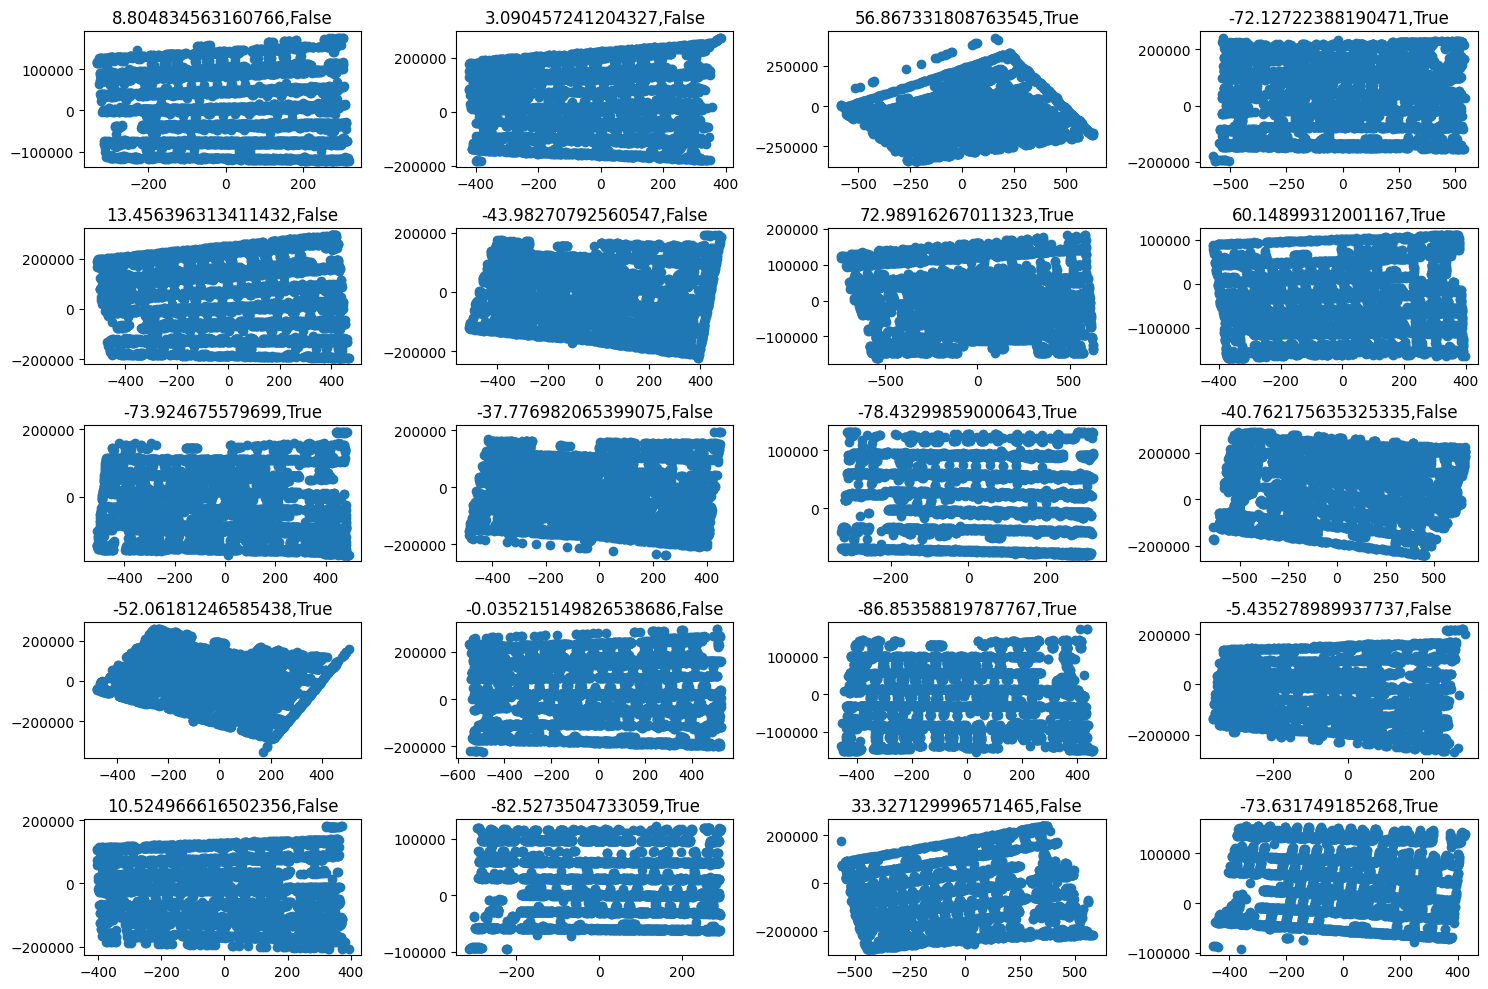

In [17]:
fig, axes =  plt.subplots(5,4, figsize = (15,10))

axes = axes.flatten()

for i in range(len(axes)):
    img_path = images[i]
    img =  Image.open(os.path.join("data", "final_renders", img_path))
    mask = Image.open(os.path.join("data", "final_renders", get_mask_for_image(img_path)))
    print(i, end = "|")
    find_rows_img(np.array(img), np.array(mask), axes[i])

plt.tight_layout()
plt.show()